In [3]:
src = "/home/vishu/reports/hbmep/notebooks/rat/lognhb/hb__4000w_4000s_4c_4t_10d_95a_fm/lcirc/rectified_logistic/model_dict.pkl"
with open(src, "rb") as f:
    mcmc, model_dict = pickle.load(f)


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [ ]:
mcmc.get_extra_fields()["num_steps"]


Array([1023, 1023, 1023, ..., 1023, 1023, 1023], dtype=int64)

In [1]:
import os
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from jax import random
from scipy import stats, integrate
from numpyro.diagnostics import hpdi

from hbmep.model import BaseModel
from hbmep import functional as F
from hbmep.util import site, generate_response_colors

from hbmep.notebooks.rat.util import annotate_heatmap, mask_upper

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
ignore_warnings = np.errstate(divide='ignore',invalid='ignore')

HOME = os.getenv("HOME")
MODEL_DIR = f"/home/vishu/reports/hbmep/notebooks/rat/lognhb/hb__4000w_4000s_4c_4t_10d_95a_fm/lcirc/rectified_logistic"
# MODEL_DIR = f"/home/vishu/reports/hbmep/notebooks/rat/lognhb/nhb__4000w_1000s_4c_1t_20d_95a_tm/lcirc/rl_no_v"
INFERENCE_FILE = os.path.join(MODEL_DIR, "inf.pkl")
MODEL_FILE = os.path.join(MODEL_DIR, "model.pkl")

MAX_INTENSITY = 9 # 2 ** 9 = 512
NUM_POINTS = 200 # reduce if ram overflows


/home/vishu/repos/refactor/hbmep/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
src = INFERENCE_FILE
with open(src, "rb") as f: df, encoder, posterior, = pickle.load(f)

src = MODEL_FILE
with open(src, "rb") as f: model, = pickle.load(f)

subjects = sorted(df['participant'].unique())
subjects_inverse = encoder['participant'].inverse_transform(subjects)
subjects_inverse

positions = sorted(df['compound_position'].unique())
positions_inverse = encoder['compound_position'].inverse_transform(positions)
positions_inverse

apost = posterior[site.a]
apost.shape

a = apost.mean(axis=0)
a.shape

labels = positions_inverse


array(['amap01', 'amap02', 'amap03', 'amap04', 'amap05', 'amap06',
       'amap07', 'amap08'], dtype=object)

array(['-C6LC', '-C6LE', '-C6LN', '-C6LNE', '-C6LNW', '-C6LS', '-C6LSE',
       '-C6LSW', '-C6LW', 'C6LE-C6LC', 'C6LE-C6LW', 'C6LN-C6LC',
       'C6LNE-C6LC', 'C6LNE-C6LSW', 'C6LNW-C6LC', 'C6LS-C6LC',
       'C6LS-C6LN', 'C6LSE-C6LC', 'C6LSE-C6LNW', 'C6LSW-C6LC',
       'C6LW-C6LC'], dtype=object)

(4000, 8, 21, 6)

(8, 21, 6)

In [3]:
vertices = list(range(9))
labels[vertices]

diam = [pos_idx for pos_idx, pos in enumerate(positions_inverse) if pos.split("-")[0] != "" and pos[-1] != "C"]
labels[diam]

radii = [pos_idx for pos_idx, pos in enumerate(positions_inverse) if pos not in labels[vertices].tolist() + labels[diam].tolist()]
labels[radii]


array(['-C6LC', '-C6LE', '-C6LN', '-C6LNE', '-C6LNW', '-C6LS', '-C6LSE',
       '-C6LSW', '-C6LW'], dtype=object)

array(['C6LE-C6LW', 'C6LNE-C6LSW', 'C6LS-C6LN', 'C6LSE-C6LNW'],
      dtype=object)

array(['C6LE-C6LC', 'C6LN-C6LC', 'C6LNE-C6LC', 'C6LNW-C6LC', 'C6LS-C6LC',
       'C6LSE-C6LC', 'C6LSW-C6LC', 'C6LW-C6LC'], dtype=object)

# Threshold


## Plots

In [4]:
def plot_data(subset):
    arr = a[:, subset, ...]
    arr.shape
    colors = generate_response_colors(len(subset), "viridis")

    nr, nc = 1 + (arr.shape[-1] + 1) // 4, 4
    fig, axes = plt.subplots(nr, nc, figsize=(5 * nc, 2.5 * nr), constrained_layout=True, squeeze=False)
    counter = 0
    for r in range(model.num_response + 1):
        ax = axes[counter // nc, counter % nc]
        for label_idx, label in enumerate(labels[subset]):
            if r == model.num_response:
                y = arr.mean(axis=-1)[..., label_idx]
                x = np.arange(y.shape[0])
            else:
                y = arr[:, label_idx, r]
                x = np.arange(y.shape[0])
            sns.lineplot(x=x, y=y, ax=ax, color=colors[label_idx], label=label, marker="o")
            ax.legend(loc='lower right', bbox_to_anchor=(1, 1))
            if r > 0:
                if ax.get_legend(): ax.get_legend().remove()
        counter += 1
    ax = axes[-1, 0]
    plt.show();


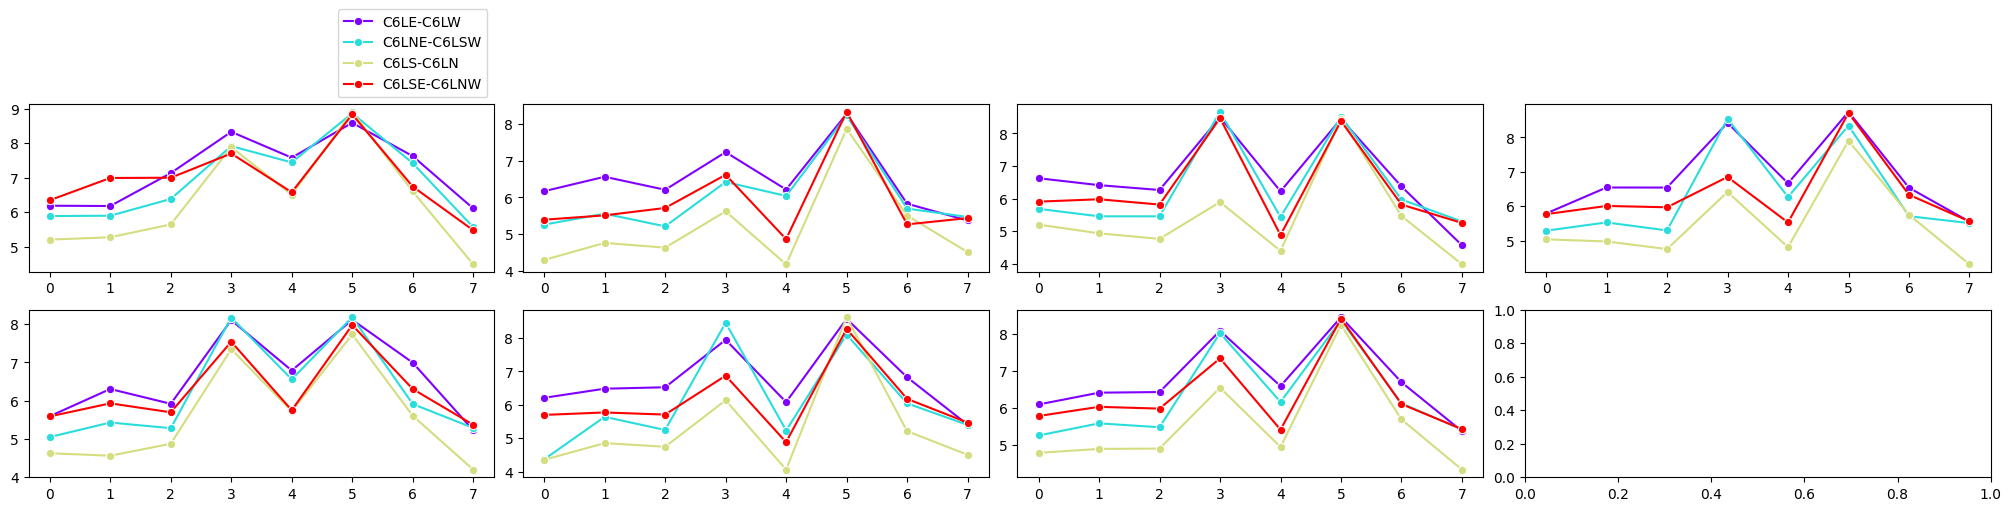

In [5]:
plot_data(diam)


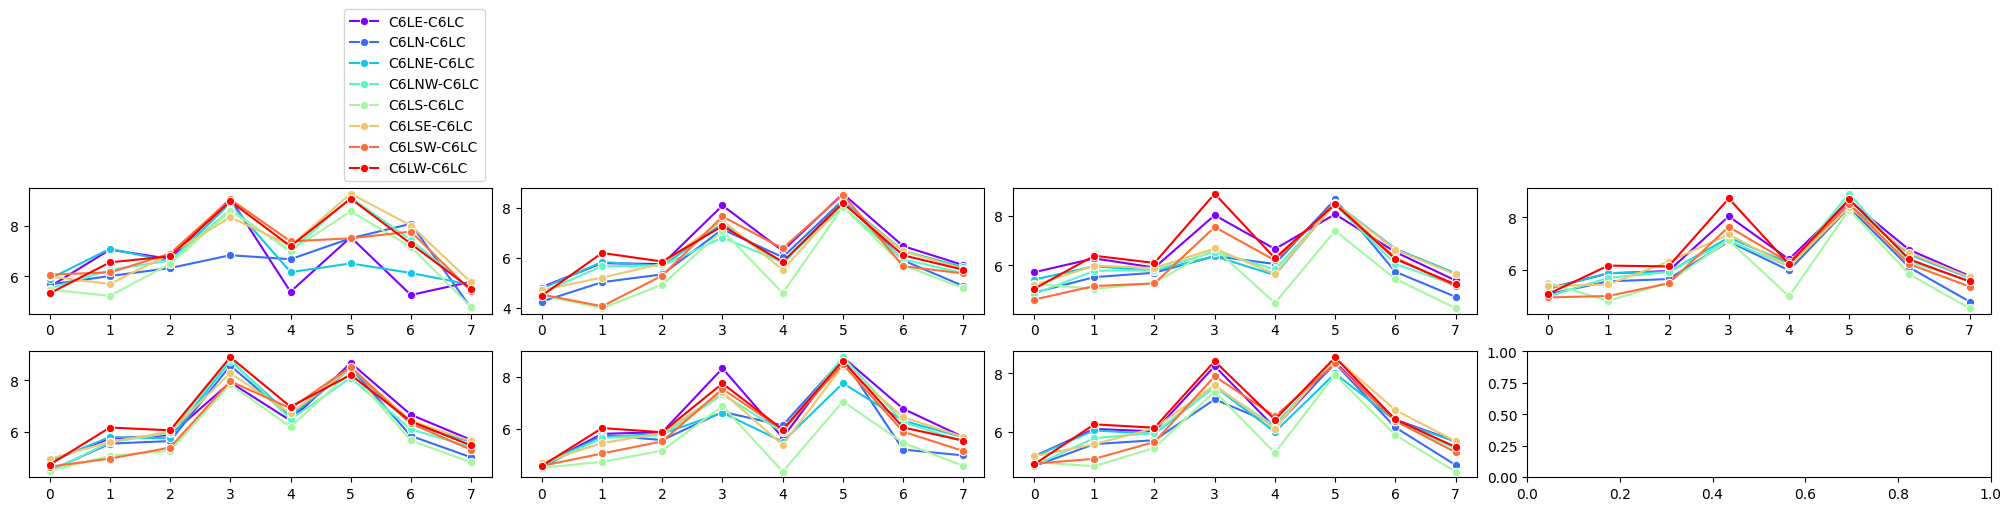

In [6]:
plot_data(radii)


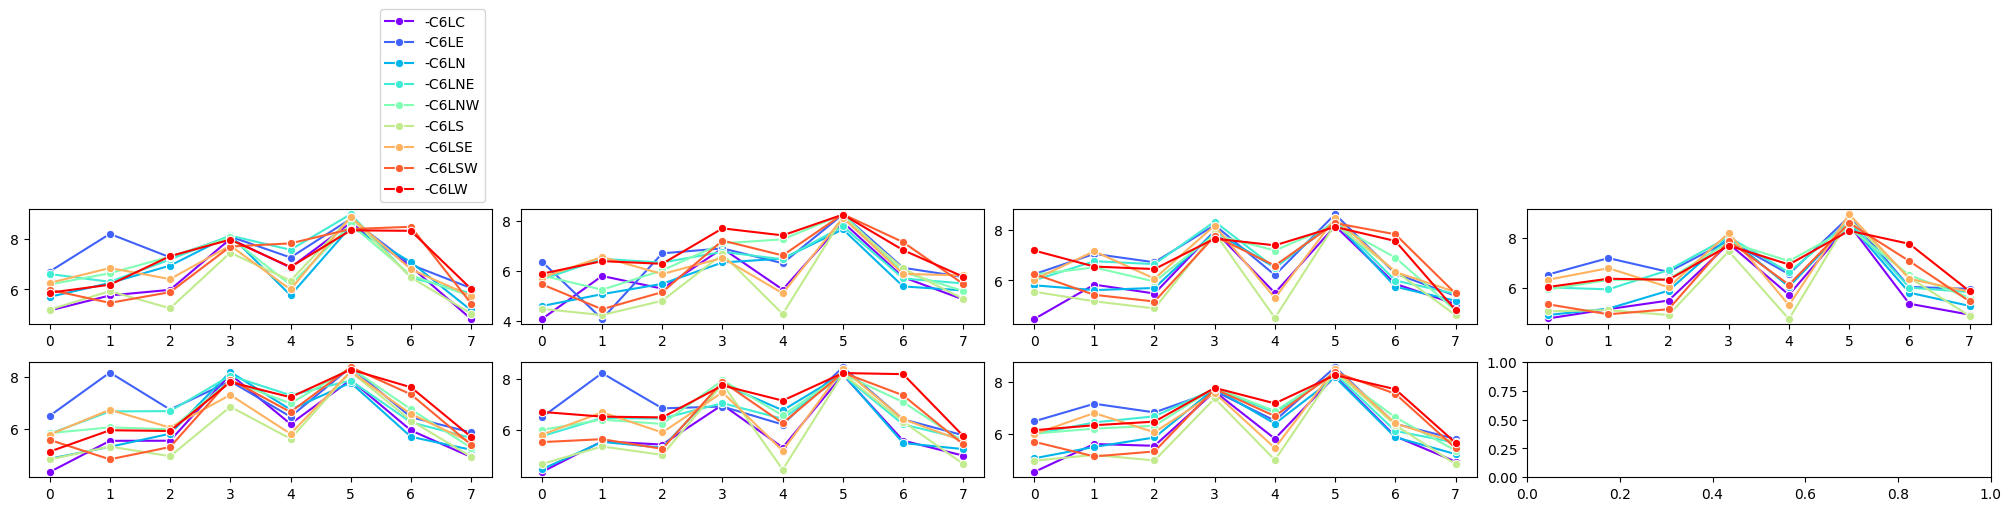

In [7]:
plot_data(vertices)


##

In [8]:
a_mean = a.mean(axis=-1)
a_mean.shape

diff = a_mean[..., None] - a_mean[:, None, :]
diff.shape

np.testing.assert_almost_equal(diff, (a[:, :, None, :] - a[:, None, :, :]).mean(axis=-1))


(8, 21)

(8, 21, 21)

In [9]:
def make_test(diff):
    test = stats.wilcoxon(diff, axis=0)
    pvalue = test.pvalue
    pvalue = mask_upper(pvalue)
    pvalue.shape

    _test = stats.ttest_1samp(diff, popmean=0)
    statistic = _test.statistic
    statistic = mask_upper(statistic)
    statistic.shape

    deg = _test.df.astype(float)
    deg = mask_upper(deg)
    deg.shape
    return pvalue, statistic, deg


def make_plot(pvalue, statistic, deg, labels):
    num_labels = len(labels)
    fig, axes = plt.subplots(1, 1, constrained_layout=True, squeeze=False, figsize=(1.2 * num_labels, .5 * num_labels))
    ax = axes[0, 0]
    sns.heatmap(pvalue, annot=False, ax=ax, cbar=False)

    # Annotate
    pvalue_annot_kws = {"ha": 'center', "va": 'center'}
    annotate_heatmap(ax, pvalue,  np.round(pvalue, 3), 0.5, 0.5, star=True, star_arr=pvalue, **pvalue_annot_kws)
    deg_annot_kws = {"ha": 'left', "va": 'bottom'}
    annotate_heatmap(ax, pvalue, deg.astype(int), 0, 1, **deg_annot_kws)
    statistic_annot_kws = {"ha": 'center', "va": 'top'}
    annotate_heatmap(ax, pvalue, np.round(statistic, 3), 0.5, 0, **statistic_annot_kws)
    ax.set_xticklabels(labels=labels, rotation=15, ha="right");
    ax.set_yticklabels(labels=labels, rotation=0);
    plt.show()
    return fig, axes


def make_compare(subset):
    curr_diff = diff[..., subset][..., subset, :]
    curr_diff.shape
    curr_labels = labels[subset]
    curr_labels
    pvalue, statistic, deg = make_test(curr_diff)
    make_plot(pvalue, statistic, deg, curr_labels)
    return pvalue, statistic, deg


/home/vishu/repos/refactor/hbmep/.venv/lib/python3.11/site-packages/scipy/stats/_wilcoxon.py:172: RuntimeWarning: invalid value encountered in divide
  z = (r_plus - mn) / se
/tmp/ipykernel_248724/3497665697.py:28: RuntimeWarning: invalid value encountered in cast
  annotate_heatmap(ax, pvalue, deg.astype(int), 0, 1, **deg_annot_kws)


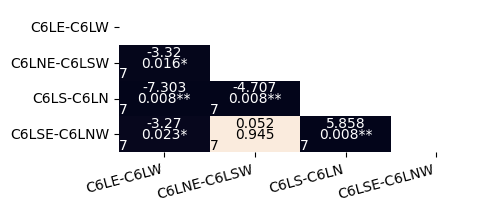

In [10]:
subset = diam.copy()
pvalue, statistic, deg = make_compare(subset)


/home/vishu/repos/refactor/hbmep/.venv/lib/python3.11/site-packages/scipy/stats/_wilcoxon.py:172: RuntimeWarning: invalid value encountered in divide
  z = (r_plus - mn) / se
/tmp/ipykernel_248724/3497665697.py:28: RuntimeWarning: invalid value encountered in cast
  annotate_heatmap(ax, pvalue, deg.astype(int), 0, 1, **deg_annot_kws)


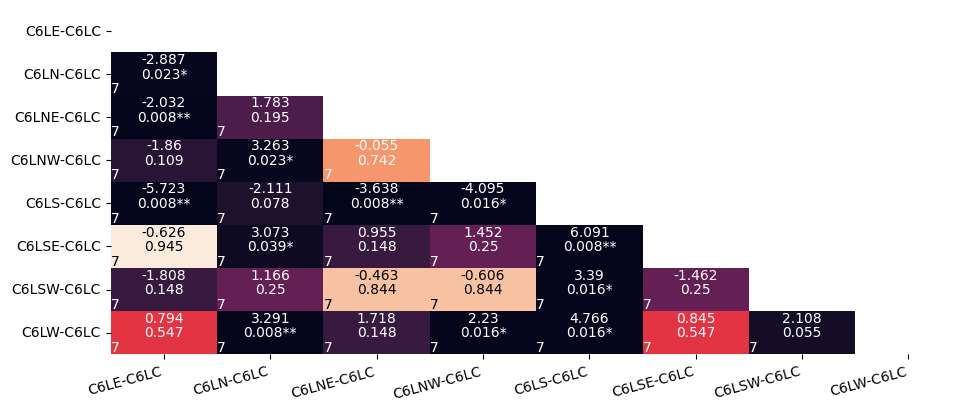

In [11]:
subset = radii.copy()
pvalue, statistic, deg = make_compare(subset)

/home/vishu/repos/refactor/hbmep/.venv/lib/python3.11/site-packages/scipy/stats/_wilcoxon.py:172: RuntimeWarning: invalid value encountered in divide
  z = (r_plus - mn) / se
/tmp/ipykernel_248724/3497665697.py:28: RuntimeWarning: invalid value encountered in cast
  annotate_heatmap(ax, pvalue, deg.astype(int), 0, 1, **deg_annot_kws)


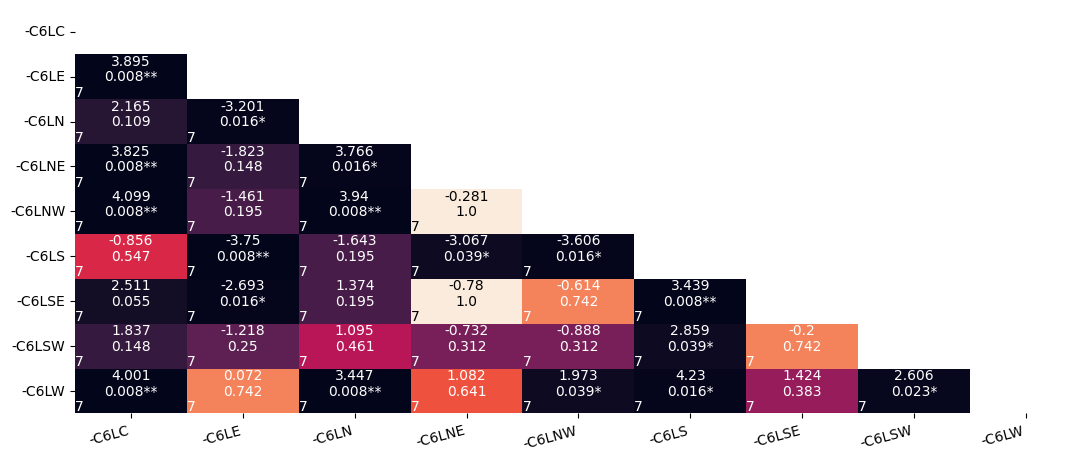

In [12]:
subset = vertices.copy()
pvalue, statistic, deg = make_compare(subset)


# Selectivity


In [13]:
asd = np.nanstd(a, axis=-1)
asd.shape


(8, 21)

## Plots

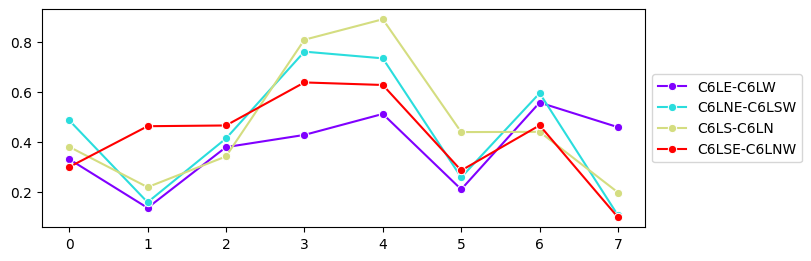

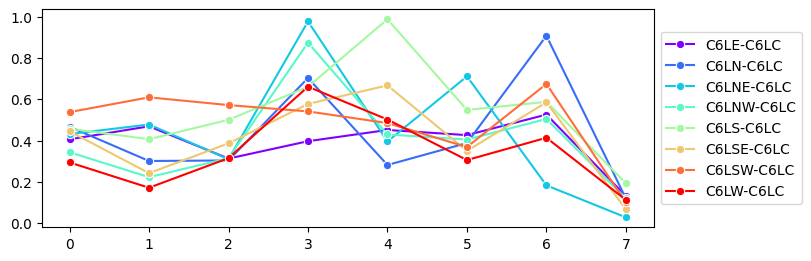

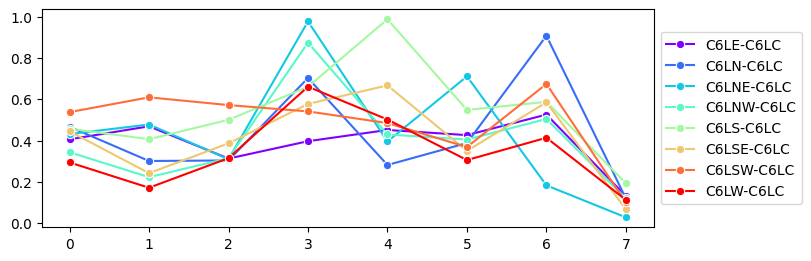

In [26]:
def plot_data(subset):
    arr = asd[:, subset]
    arr.shape
    colors = generate_response_colors(len(subset), "viridis")

    nr, nc = 1, 1
    fig, axes = plt.subplots(nr, nc, figsize=(8, 2.5), constrained_layout=True, squeeze=False)
    counter = 0
    ax = axes[0, 0]
    for label_idx, label in enumerate(labels[subset]):
        y = arr[:, label_idx]
        x = np.arange(y.shape[0])
        sns.lineplot(x=x, y=y, ax=ax, color=colors[label_idx], label=label, marker="o")
        ax.legend(loc='center left', bbox_to_anchor=(1, .5))
    plt.show();

plot_data(diam)
plot_data(radii)
plot_data(radii)
